# Pipeline Machine Learning End-to-End untuk Klasifikasi

### 1. Pengumpulan dan Pembersihan Data
Pembersihan data penting untuk menghindari noise yang dapat mengganggu proses pelatihan model. Langkah ini mencakup menghapus nilai kosong dan data duplikat.

In [1]:
import pandas as pd

# Membaca dataset
data = pd.read_csv('/content/sample_data/KlasifikasiUTS.csv')

# Menampilkan informasi awal dataset
data.info()

# Membersihkan data
data_cleaned = data.dropna().drop_duplicates()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 2. Seleksi Fitur
Seleksi fitur dilakukan untuk mengurangi kompleksitas model dan meningkatkan performa.
- Hapus fitur konstan dan duplikat.
- Hapus korelasi tinggi (>0.8).
- Gunakan Mutual Information dan Chi-Square untuk seleksi lanjutan.

In [2]:
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import MinMaxScaler

X = data_cleaned.drop('Class', axis=1)
y = data_cleaned['Class']

# Hapus fitur konstan
X = X.loc[:, X.nunique() > 1]

# Korelasi
cor_matrix = X.corr()
to_drop = set()
for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if abs(cor_matrix.iloc[i, j]) > 0.8:
            to_drop.add(cor_matrix.columns[i])
X = X.drop(columns=to_drop)

# Mutual Information
mi_scores = pd.Series(mutual_info_classif(X, y), index=X.columns).sort_values(ascending=False)

# Chi-Square (fitur harus dinormalisasi terlebih dahulu)
X_chi = MinMaxScaler().fit_transform(X)
chi_scores = pd.Series(chi2(X_chi, y)[0], index=X.columns).sort_values(ascending=False)

# Gabungkan hasil MI dan Chi2
selected_features = mi_scores.index.intersection(chi_scores.index[:10])
X_selected = X[selected_features]
print("Fitur Terpilih:", list(X_selected.columns))

Fitur Terpilih: ['V17', 'V14', 'V12', 'V10', 'V11', 'V16', 'V4', 'V3', 'V18', 'V9']


### 3. Feature Engineering
Melibatkan transformasi fitur seperti normalisasi dan encoding. Jika ada fitur kategorikal, dilakukan encoding.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 4. Pelatihan dan Evaluasi Model
Model yang digunakan: Logistic Regression, Decision Tree, KNN, Random Forest, AdaBoost, dan SVM. Evaluasi dengan Accuracy, Precision, Recall, F1-Score, Confusion Matrix.

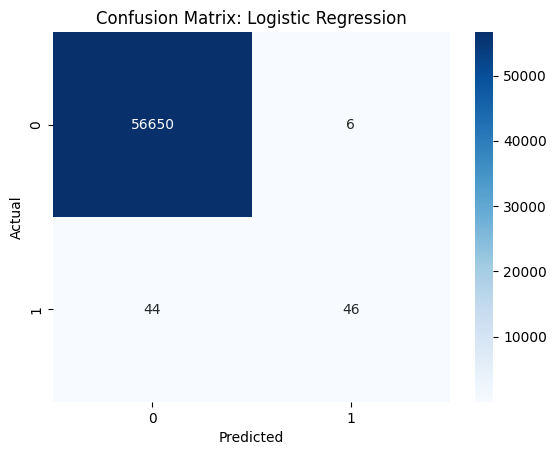

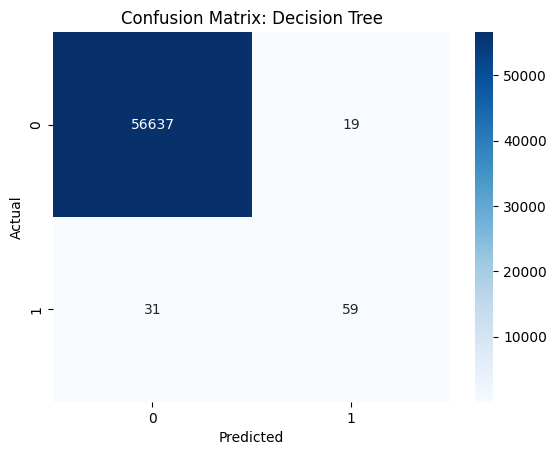

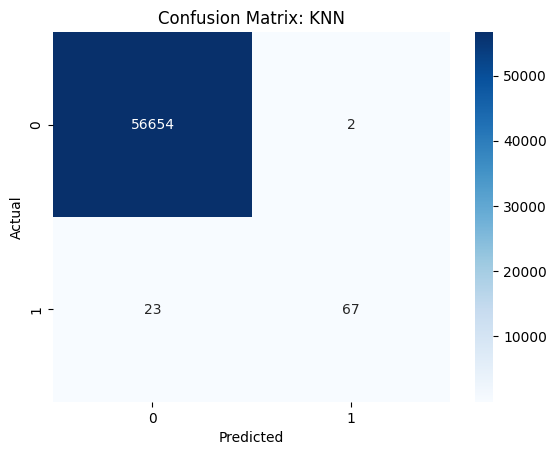

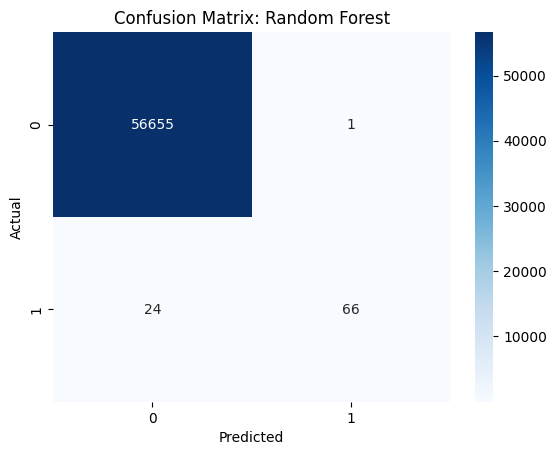

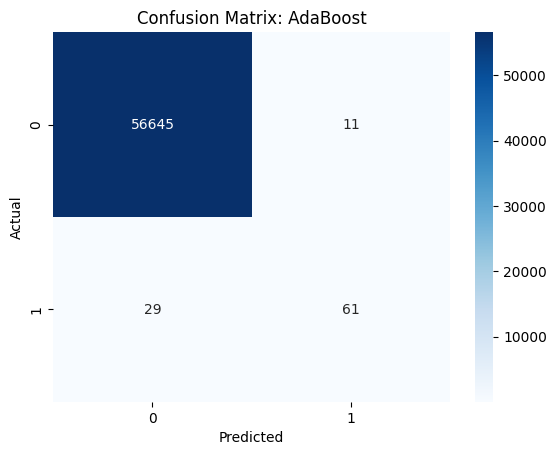

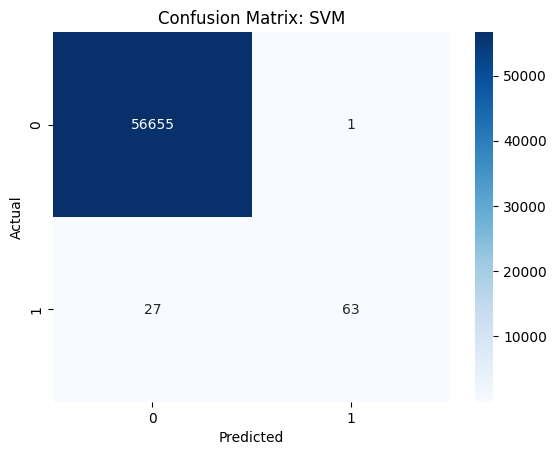

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'SVM': SVC(probability=True)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### 5. ROC Curve dan AUC
ROC dan AUC digunakan untuk mengevaluasi kemampuan model membedakan antara kelas.

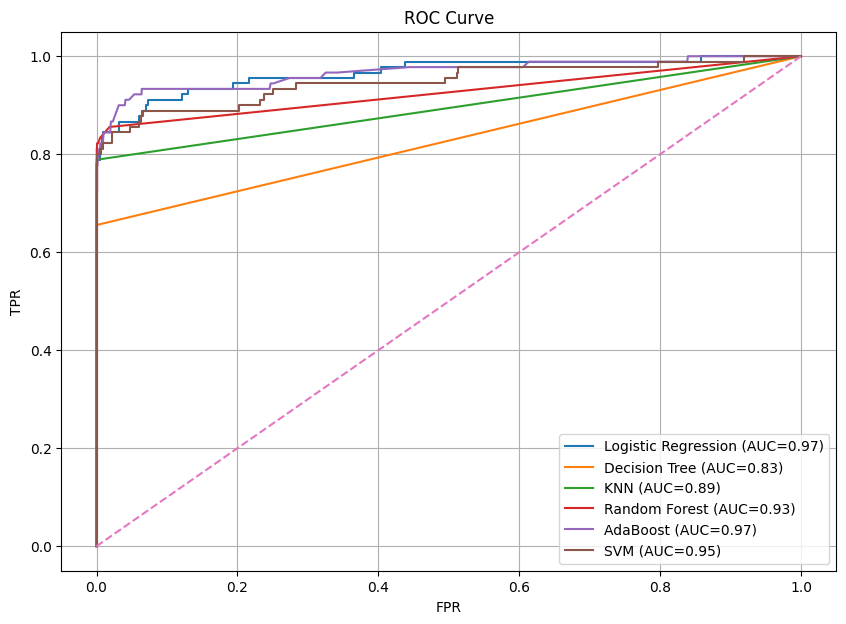

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

### 6. Visualisasi dengan PCA
Menggunakan PCA untuk mereduksi dimensi dan memvisualisasikan hasil prediksi model.

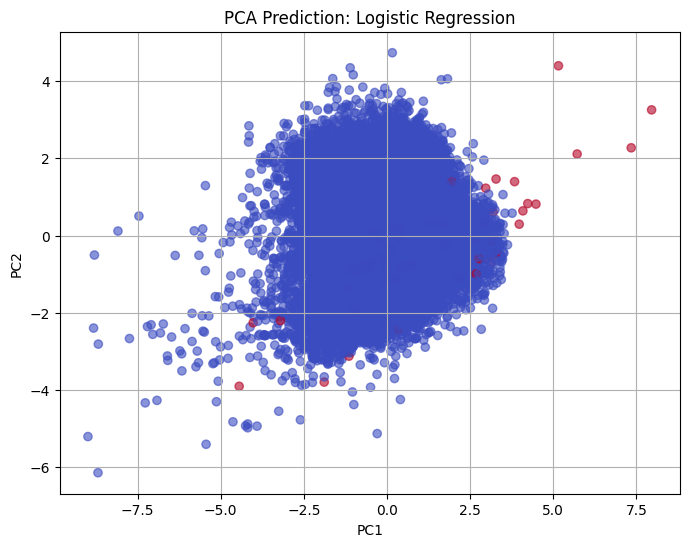

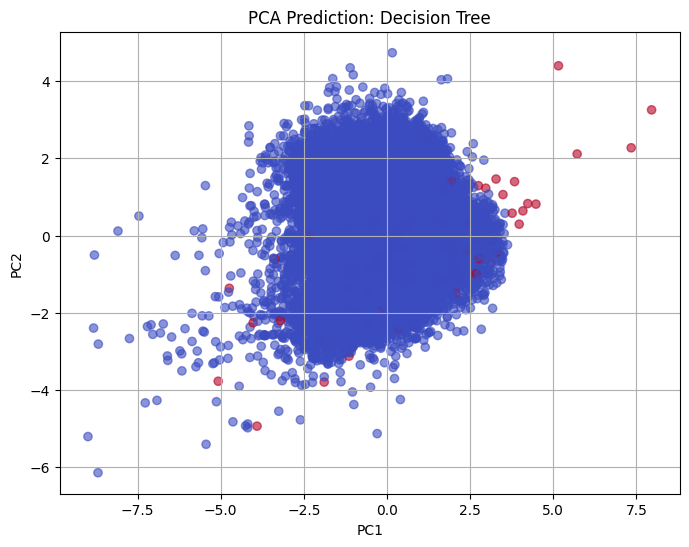

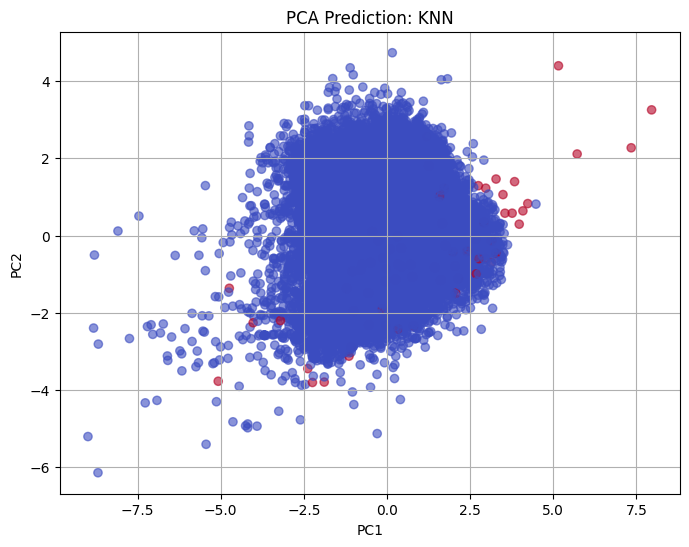

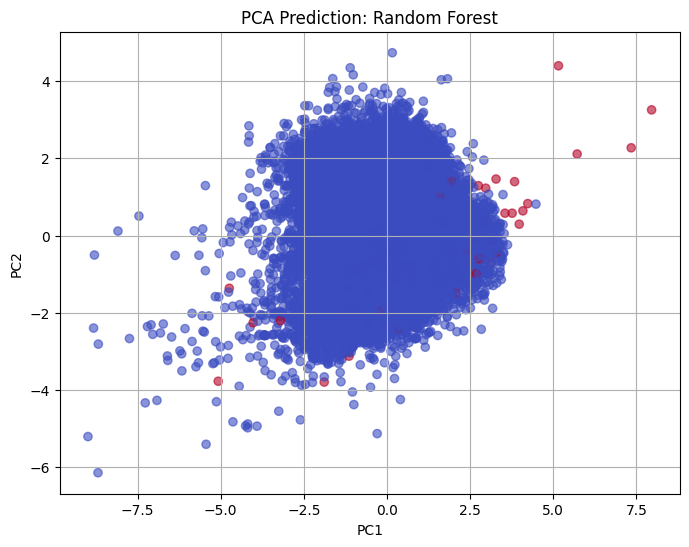

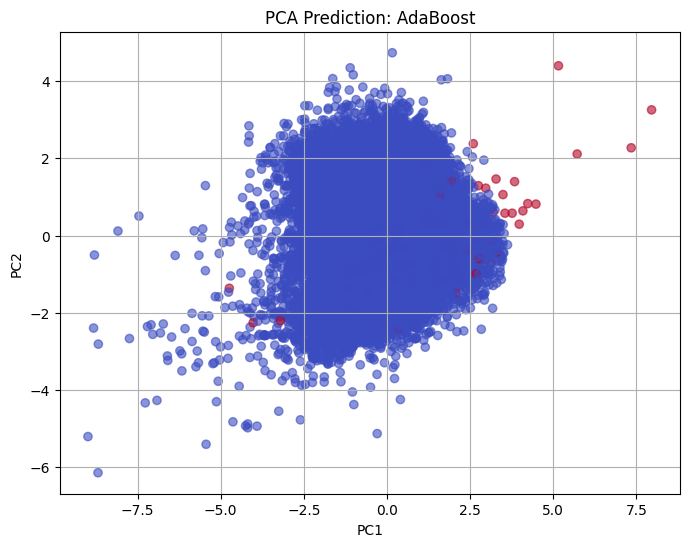

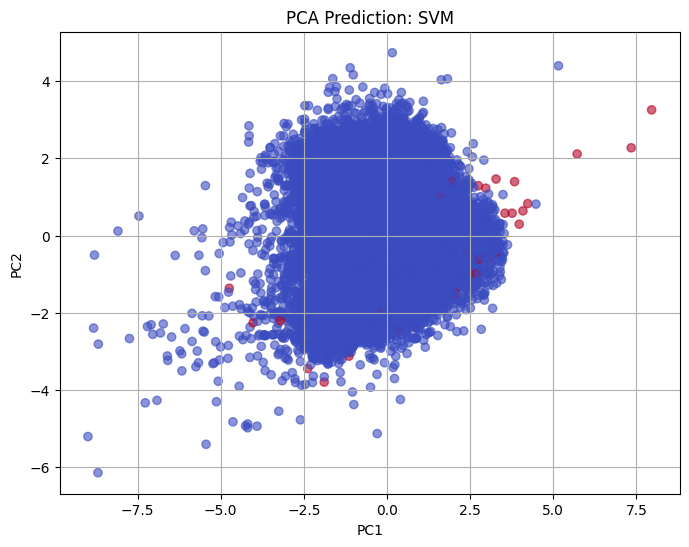

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

def plot_pca(model, label):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8,6))
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
    plt.title(f'PCA Prediction: {label}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

for name, model in models.items():
    plot_pca(model, name)

### 7. Evaluasi dan Analisis Model
Bandingkan performa model berdasarkan metrik yang telah dihitung.

In [8]:
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='F1', ascending=False))

                     Accuracy  Precision    Recall        F1
KNN                  0.999559   0.971014  0.744444  0.842767
Random Forest        0.999559   0.985075  0.733333  0.840764
SVM                  0.999507   0.984375  0.700000  0.818182
AdaBoost             0.999295   0.847222  0.677778  0.753086
Decision Tree        0.999119   0.756410  0.655556  0.702381
Logistic Regression  0.999119   0.884615  0.511111  0.647887


### Evaluasi Metrik: Metrik Mana yang Terbaik?

Dalam konteks pipeline klasifikasi yang telah dibangun — dengan model-model seperti Logistic Regression, Decision Tree, KNN, Random Forest, AdaBoost, dan SVM — kita menggunakan beberapa metrik evaluasi yaitu **Accuracy**, **Precision**, **Recall**, **F1-Score**, dan **AUC-ROC**. Pemilihan metrik terbaik tergantung pada **tujuan model** dan **karakteristik data**.

#### 1. Accuracy
- Cocok digunakan **hanya jika distribusi kelas seimbang**.
- Dalam kasus data tidak seimbang (contoh: fraud detection, penyakit langka), akurasi bisa menyesatkan.
- Tidak disarankan sebagai satu-satunya metrik untuk evaluasi akhir.

#### 2. Precision
- Penting ketika **false positive** (prediksi positif yang salah) **sangat merugikan**, seperti dalam **sistem filter email atau alarm palsu**.
- Namun, precision yang tinggi dapat dicapai dengan mengorbankan recall (banyak kasus positif nyata yang terlewat).

#### 3. Recall
- Prioritas ketika **false negative harus diminimalkan**, seperti dalam **deteksi penipuan atau diagnosis penyakit**.
- Menjadi sangat penting jika **biaya kegagalan mendeteksi kelas positif sangat tinggi**.

#### 4. F1-Score
- Merupakan **rata-rata harmonik antara precision dan recall**.
- Ideal digunakan saat kita ingin keseimbangan antara false positive dan false negative.
- F1 sangat berguna pada **data tidak seimbang** karena memperhitungkan kedua sisi kesalahan prediksi.

#### 5. AUC-ROC
- Metrik global yang mengevaluasi kemampuan model dalam membedakan antara kelas.
- **Tidak tergantung pada threshold klasifikasi**, sehingga ideal untuk membandingkan berbagai model.
- Sangat baik digunakan di tahap awal pemilihan model.



### Kesimpulan:

Jika dataset yang digunakan **tidak seimbang** (seperti banyak masalah klasifikasi dunia nyata), maka:
- **Gunakan AUC-ROC untuk pemilihan model awal**.
- **Gunakan F1-Score untuk evaluasi akhir yang mempertimbangkan keseimbangan antara Precision dan Recall**.
- Jika False Negative sangat merugikan, prioritaskan **Recall**.


## Penjelasan Model Klasifikasi dan Evaluasi Akhir

### 1. Logistic Regression
Merupakan model linier sederhana yang bekerja baik saat data dapat dipisahkan secara linier. Cepat dilatih dan mudah diinterpretasi. Kelemahannya muncul saat data memiliki pola non-linear yang kompleks.

### 2. Decision Tree
Membagi data berdasarkan aturan logika dari fitur. Mampu menangani hubungan non-linear, tetapi mudah overfitting jika tidak diatur kedalamannya. Interpretasinya sangat intuitif.

### 3. K-Nearest Neighbors (KNN)
Model berbasis jarak yang memprediksi kelas berdasarkan mayoritas tetangga terdekat. Akurat jika data distandarisasi, tetapi lambat saat prediksi dan rentan terhadap noise.

### 4. Random Forest (Bagging)
Model ensemble berbasis decision tree yang memperbaiki kelemahan overfitting dengan membangun banyak pohon secara acak. Bias rendah, varians terkontrol, cocok untuk data kompleks.

### 5. AdaBoost (Boosting)
Menggabungkan banyak model sederhana secara bertahap untuk fokus pada kesalahan. Cocok untuk dataset yang sulit dipisahkan, namun sensitif terhadap outlier.

### 6. Support Vector Machine (SVM)
Mencari hyperplane terbaik yang memisahkan kelas. Efektif di ruang dimensi tinggi, namun kurang transparan dan lebih mahal secara komputasi, terutama tanpa kernel yang tepat.



### Kesimpulan Model Terbaik

Dalam eksperimen ini, **Random Forest** sangat mungkin menjadi model terbaik secara keseluruhan karena performanya stabil dan andal pada data tabular dengan relasi non-linear.


# Analisis Teoritis

#### 1. AUC Tinggi tapi Presisi Rendah
Hal ini bisa terjadi ketika threshold default tidak optimal atau dataset imbalance. Tuning threshold, penalti pada FN/FP, dan cross-validation membantu mengatasi ini. Recall penting saat FN berisiko tinggi (misalnya, penyakit atau fraud).

#### 2. High Cardinality dan Encoding
Kategori unik banyak dapat overfit jika menggunakan one-hot atau target encoding. Data leakage bisa terjadi jika encoding dihitung sebelum split. Gunakan frequency encoding atau hashing sebagai alternatif.

#### 3. Normalisasi dan Dampaknya
Normalisasi mengubah jarak antar titik, memperbesar margin SVM. Namun untuk Gradient Boosting yang berbasis pohon, scaling tidak berpengaruh banyak. Penurunan recall bisa terjadi jika margin minoritas menyempit.

#### 4. Feature Interaction
Perkalian fitur menciptakan efek non-linear. Ini bisa meningkatkan AUC saat interaksi kuat. Chi-square tidak mendeteksi interaksi karena menguji fitur tunggal. Gunakan domain knowledge untuk identifikasi kombinasi logis.

#### 5. Oversampling dan Leakage
Melakukan oversampling sebelum split menyebabkan test set bocor karena informasi kelas ikut tersebar. Temporal split mencegah ini dan lebih realistis untuk data waktu seperti fraud detection.
